In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydicom
from pydicom import dcmread
from pathlib import Path
import glob
import time
import dicom_numpy
import nrrd

In [2]:

def extract_voxel_data(list_of_dicom_files):
    datasets = [pydicom.read_file(f) for f in list_of_dicom_files]
    try:
        voxel_ndarray, ijk_to_xyz = dicom_numpy.combine_slices(datasets)
    except dicom_numpy.DicomImportException as e:
        # invalid DICOM data
        raise
    return voxel_ndarray

In [3]:
# Reading labels
Labels = {}

Label_Folders = glob.glob("C:\\Users\\obazgir\\Desktop\\MRI_Prostate\\NCI_ISBI_Challenge-Prostate3T_Training_Segmentations\\*.nrrd")
for lab_fold in Label_Folders:
    readdata, header = nrrd.read(lab_fold)
    Label_Name = lab_fold.split("\\")[-1].split(".")[0]
    Labels[Label_Name] = readdata[:,:,7]

print(Labels.keys())

dict_keys(['Prostate3T-01-0001', 'Prostate3T-01-0002', 'Prostate3T-01-0003', 'Prostate3T-01-0004', 'Prostate3T-01-0005', 'Prostate3T-01-0006', 'Prostate3T-01-0007', 'Prostate3T-01-0008', 'Prostate3T-01-0009', 'Prostate3T-01-0010', 'Prostate3T-01-0011', 'Prostate3T-01-0012', 'Prostate3T-01-0013', 'Prostate3T-01-0014', 'Prostate3T-01-0015', 'Prostate3T-01-0016', 'Prostate3T-01-0017', 'Prostate3T-01-0018', 'Prostate3T-01-0019', 'Prostate3T-01-0020', 'Prostate3T-01-0021', 'Prostate3T-01-0022', 'Prostate3T-01-0023', 'Prostate3T-01-0024', 'Prostate3T-01-0025', 'Prostate3T-01-0026', 'Prostate3T-01-0027', 'Prostate3T-01-0028', 'Prostate3T-01-0029', 'Prostate3T-01-0030'])


In [4]:
# Reading the 3D MRIs
DICOM_IM = {}
Folders = glob.glob('C:\\Users\\obazgir\\Desktop\\MRI_Prostate\\Prostate_3T_new\\Prostate-3T\\Prostate*')
for folder in Folders:
    sub_folders = folder + "\\*\\*\\*.dcm"
    files = glob.glob(sub_folders)
    NP_Vox = extract_voxel_data(files)
    DICOM_IM[folder.split("\\")[-1]] = NP_Vox[:,:,7]

print(DICOM_IM.keys())

dict_keys(['Prostate3T-01-0001', 'Prostate3T-01-0002', 'Prostate3T-01-0003', 'Prostate3T-01-0004', 'Prostate3T-01-0005', 'Prostate3T-01-0006', 'Prostate3T-01-0007', 'Prostate3T-01-0008', 'Prostate3T-01-0009', 'Prostate3T-01-0010', 'Prostate3T-01-0011', 'Prostate3T-01-0012', 'Prostate3T-01-0013', 'Prostate3T-01-0014', 'Prostate3T-01-0015', 'Prostate3T-01-0016', 'Prostate3T-01-0017', 'Prostate3T-01-0018', 'Prostate3T-01-0019', 'Prostate3T-01-0020', 'Prostate3T-01-0021', 'Prostate3T-01-0022', 'Prostate3T-01-0023', 'Prostate3T-01-0024', 'Prostate3T-01-0025', 'Prostate3T-01-0026', 'Prostate3T-01-0027', 'Prostate3T-01-0028', 'Prostate3T-01-0029', 'Prostate3T-01-0030', 'Prostate3T-01-0031', 'Prostate3T-01-0032', 'Prostate3T-01-0033', 'Prostate3T-01-0034', 'Prostate3T-01-0035', 'Prostate3T-01-0036', 'Prostate3T-01-0037', 'Prostate3T-01-0038', 'Prostate3T-01-0039', 'Prostate3T-01-0040', 'Prostate3T-01-0041', 'Prostate3T-01-0042', 'Prostate3T-01-0043', 'Prostate3T-01-0044', 'Prostate3T-01-0045',

In [5]:
# Finding the commong samples between labels and MRIs

MRISet = set(DICOM_IM.keys())
LebelSet = set(Labels.keys())
Common_Keys = []

for label in LebelSet.intersection(MRISet):
    Common_Keys.append(label)

# 3D U-Net


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import cv2

In [7]:
#from scipy.misc import imresize
from skimage.transform import rescale, resize

TrainKeys = Common_Keys[:20]
ValKeys = Common_Keys[20:]

Im_Train = np.zeros([len(TrainKeys),320,320,1])
Im_Val = np.zeros([len(ValKeys),320,320,1])

Label_Train = np.zeros([len(TrainKeys),3,320,320])
Label_Val = np.zeros([len(ValKeys),3,320,320])

KeepTrainKeys = []
for i in range(len(TrainKeys)):
    a = DICOM_IM[TrainKeys[i]].shape 
    b = Labels[TrainKeys[i]].shape
    if a == b:
        if a == (320,320):
            Im_Train[i,:,:,0]= DICOM_IM[TrainKeys[i]]
            #Label_Train[i,:,:,0] = Labels[TrainKeys[i]]
            # One Hot encoding
            #print(i)
            Label_Train_tens = torch.from_numpy(Labels[TrainKeys[i]])
            label_one_hot = torch.nn.functional.one_hot(Label_Train_tens.to(torch.int64),3).numpy()
            for j in range(3):
                Label_Train[i,j,:,:] = label_one_hot[:,:,j] 
            KeepTrainKeys.append(TrainKeys[i])
KeepValKeys = []
for i in range(len(ValKeys)):
    a = DICOM_IM[ValKeys[i]].shape
    b = Labels[ValKeys[i]].shape
    if a == b:
        if a == (320,320):
            Im_Val[i,:,:,0]= DICOM_IM[ValKeys[i]]
            #Label_Val[i,:,:,0]= Labels[ValKeys[i]]
            Label_Val_tens = torch.from_numpy(Labels[ValKeys[i]])
            label_one_hot = torch.nn.functional.one_hot(Label_Val_tens.to(torch.int64),3).numpy()
            for j in range(3):
                Label_Val[i,j,:,:] = label_one_hot[:,:,j]
            KeepValKeys.append(ValKeys[i])
    
#Normalizing
MX = Im_Train.max()

def normalizer(Set, MX):
    for i in range(Set.shape[0]):
        Set[i,:,:,:] = Set[i,:,:,:]/MX
    return Set

Im_Train = normalizer(Im_Train,MX)
Im_Val = normalizer(Im_Val,MX)

In [8]:
Train_IM_Dic = {}
Val_IM_Dic = {}
Train_Lab_Dic = {}
Val_Lab_Dic = {}
for i in range(len(KeepTrainKeys)):
    Train_IM_Dic[KeepTrainKeys[i]] = Im_Train[i,:,:,:]
    Train_Lab_Dic[KeepTrainKeys[i]] = Label_Train[i,:,:,:]

for i in range(len(KeepValKeys)):
    Val_IM_Dic[KeepValKeys[i]] = Im_Val[i,:,:,:]
    Val_Lab_Dic[KeepValKeys[i]] = Label_Val[i,:,:,:]


In [9]:
Im_Train1 = Im_Train[:1,:,:,:] 
Label_Train1 = Label_Train[:1,:,:,:] 
TrainKeys1 = TrainKeys[:1]

Im_Val1 = Im_Val[:1,:,:,:] 
Label_Val1 = Label_Val[:1,:,:,:] 
ValKeys1 = ValKeys[:1]

Im_Train1.shape

(1, 320, 320, 1)

# U-Net

In [10]:
# Prepare dataset and dataloader
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
#import simulation

#partition = {'train':TrainKeys, 'validation':ValKeys}

#class SimDataset(Dataset):
#    def __init__(self, count, transform=None):
#        self.input_images, self.target_masks = generate_random_data(192, 192, count=count)
#        self.transform = transform

#    def __len__(self):
#        return len(self.input_images)

#    def __getitem__(self, idx):
#        image = self.input_images[idx]
#        mask = self.target_masks[idx]
#        if self.transform:
#            image = self.transform(image)

#        return [image, mask]

class ProsDataset(Dataset):    
    def __init__(self,MRI,Mask,Keys, transform=None):
        self.input_images = MRI
        self.target_masks = Mask
        self.transform = transform
        self.Keys = Keys
    def __len__(self):
        return len(self.Keys)

    def __getitem__(self, idx):
        image = self.input_images[idx]
        mask = self.target_masks[idx]
        if self.transform:
            image = self.transform(image)

        return [image, mask]


# use the same transformations for train/val in this example
trans = transforms.Compose([
    transforms.ToTensor()#,
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

#train_set = SimDataset(2000, transform = trans)
#val_set = SimDataset(200, transform = trans)
train_set = ProsDataset(Im_Train1,Label_Train1,TrainKeys1, transform = trans)
val_set = ProsDataset(Im_Val1,Label_Val1,ValKeys1, transform = trans)

image_datasets = {
    'train': train_set, 'val': val_set
}

batch_size = 1

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

In [60]:
import torch
import torch.nn as nn

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(1, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        self.soft_max = nn.Softmax()
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        ouit = self.soft_max(out)
        
        return out

In [43]:
import torch
import torch.nn as nn

def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

In [44]:
from torchsummary import summary
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet(3)
model = model.to(device)

summary(model, input_size=(1, 320, 320))



Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       640
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       36,928
|    └─ReLU: 2-4                         --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-5                       73,856
|    └─ReLU: 2-6                         --
|    └─Conv2d: 2-7                       147,584
|    └─ReLU: 2-8                         --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-9                       295,168
|    └─ReLU: 2-10                        --
|    └─Conv2d: 2-11                      590,080
|    └─ReLU: 2-12                        --
├─Sequential: 1-4                        --
|    └─Conv2d: 2-13                      1,180,160
|    └─ReLU: 2-14                        --
|    └─Conv2d: 2-15                      2,359,808
|    └─ReLU: 2-16                        --
├─MaxPool2d: 1-5                 

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       640
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       36,928
|    └─ReLU: 2-4                         --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-5                       73,856
|    └─ReLU: 2-6                         --
|    └─Conv2d: 2-7                       147,584
|    └─ReLU: 2-8                         --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-9                       295,168
|    └─ReLU: 2-10                        --
|    └─Conv2d: 2-11                      590,080
|    └─ReLU: 2-12                        --
├─Sequential: 1-4                        --
|    └─Conv2d: 2-13                      1,180,160
|    └─ReLU: 2-14                        --
|    └─Conv2d: 2-15                      2,359,808
|    └─ReLU: 2-16                        --
├─MaxPool2d: 1-5                 

In [61]:
from collections import defaultdict
import torch.nn.functional as F


def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))    

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [87]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 3

model = UNet(num_class).to(device).double()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.5)

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=10)

cpu
Epoch 0/9
----------
LR 0.0001


C:\Users\obazgir\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


train: bce: 0.707410, dice: 0.770623, loss: 0.739017
val: bce: 0.704961, dice: 0.759237, loss: 0.732099
saving best model
0m 15s
Epoch 1/9
----------
LR 0.0001
train: bce: 0.706040, dice: 0.770436, loss: 0.738238
val: bce: 0.703629, dice: 0.759047, loss: 0.731338
saving best model
0m 15s
Epoch 2/9
----------
LR 0.0001
train: bce: 0.704708, dice: 0.770249, loss: 0.737478
val: bce: 0.702272, dice: 0.758817, loss: 0.730544
saving best model
0m 16s
Epoch 3/9
----------
LR 0.0001
train: bce: 0.703337, dice: 0.770025, loss: 0.736681
val: bce: 0.700904, dice: 0.758559, loss: 0.729731
saving best model
0m 15s
Epoch 4/9
----------
LR 0.0001
train: bce: 0.701935, dice: 0.769766, loss: 0.735850
val: bce: 0.699450, dice: 0.758283, loss: 0.728867
saving best model
0m 15s
Epoch 5/9
----------
LR 0.0001
train: bce: 0.700446, dice: 0.769485, loss: 0.734965
val: bce: 0.697951, dice: 0.758008, loss: 0.727979
saving best model
0m 15s
Epoch 6/9
----------
LR 0.0001
train: bce: 0.698891, dice: 0.769202, lo

In [33]:
def dice_score(pred, target, smooth = 1.):
    
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim = 2).sum(dim = 2)
    
    loss = (((2. * intersection + smooth) / (pred.sum(dim = 2).sum(dim = 2) + target.sum(dim = 2).sum(dim = 2) + smooth)))
    
    return loss.mean()

C:\Users\obazgir\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Dice :  0.012973368159526948
(1, 3, 320, 320)


Text(0.5, 1.0, 'Prediction')

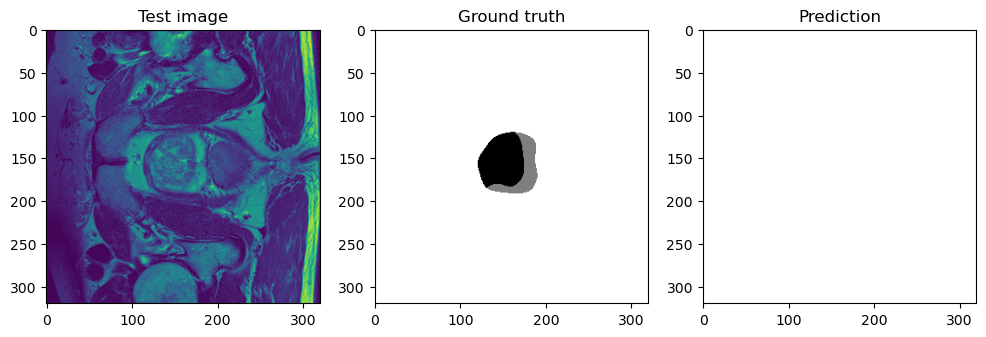

In [90]:
# prediction

import math

model.eval()   # Set model to evaluate mode


test_loader = dataloaders['val']

inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

pred = model(inputs)

dice = dice_score(pred, labels)
#print(type(dice))
print("Dice : ", dice.detach().numpy())

pred = pred.data.cpu().numpy()
labels = labels.data.cpu().numpy()

print(pred.shape)
#print(inputs.numpy().shape)
#print(labels.shape)

Test_image = inputs.numpy()[0,0,:,:]
Test_image.shape

labels_back = np.argmax(labels, axis=1)[0,:,:]
pred_back = np.argmin(pred, axis=1)[0,:,:]
#print(pred_back.shape)


#dice = dice_score(pred, labels)
#print(type(dice))
#print("Dice : ", dice.detach().numpy())
# Change channel-order and make 3 channels for matplot
#input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]

# Map each channel (i.e. class) to each color
#target_masks_rgb = [masks_to_colorimg(x) for x in labels.cpu().numpy()]
#pred_rgb = [masks_to_colorimg(x) for x in pred]

#plot_side_by_side([Test_image, target_masks_rgb, pred_rgb])
plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(131)
plt.imshow(Test_image)
plt.title("Test image")

plt.subplot(132)
plt.imshow(labels_back*125, cmap = 'binary')
plt.title("Ground truth")


plt.subplot(133)
plt.imshow(pred_back*125, cmap = 'binary')
plt.title("Prediction")

In [86]:
print(pred_back.shape)
print(labels_back.shape)

LABEL= labels
Dice = []
for i in range(3):
    dice = np.sum(pred_back[labels_back==i])*2 / (np.sum(pred_back) + np.sum(labels_back))
    Dice.append(dice)

print("Dice : ", np.array(Dice).mean())

(320, 320)
(320, 320)
Dice :  0.6450474966613752
